In [2]:
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split, ShuffleSplit

In [7]:
!mkdir data

In [8]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [9]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [10]:
df = pd.io.sql.read_sql(
    """
    select commits.num_commits, views.pageviews, diff.*
    from
    (
        select uid, avg(diff)
        from
        (
            select uid, cast((julianday(test_control.checker_ts) - julianday(datetime(deadlines.deadlines, 'unixepoch'))) * 24 as integer) as diff
            from
            (
                select uid, checker_ts, labname from test
                union
                select uid, checker_ts, labname from control
            ) as test_control left join deadlines on test_control.labname = deadlines.labs
            where not test_control.labname = 'project1'
        )
        group by uid
    ) as diff left join
    (
        select uid, count(*) as num_commits
        from checker
        where uid like 'user_%' and not labname = 'project1'
        group by uid
    ) as commits on diff.uid = commits.uid left join 
    (
        select uid, count(*) as pageviews
        from pageviews
        group by uid
    ) as views on diff.uid = views.uid
    order by uid
    """, conn, index_col='uid'
)

In [11]:
conn.close()

In [12]:
df = df.fillna(0)

In [13]:
df = df.reindex(sorted(df.index, key=len))

In [14]:
df.head()

,num_commits,pageviews,avg(diff)
uid,,,
user_1,62,28.0,-64.4
user_2,46,0.0,-137.2
user_3,18,317.0,-105.4
user_4,40,0.0,-175.6
user_6,15,0.0,-62.6


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, user_1 to user_31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_commits  29 non-null     int64  
 1   pageviews    29 non-null     float64
 2   avg(diff)    29 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 928.0+ bytes


In [16]:
df.to_csv('data/regression.csv')

In [21]:
uploaded = drive.CreateFile({'title': 'regression.csv'})
uploaded.SetContentFile('data/regression.csv')
uploaded.Upload()

In [17]:
X = df.drop('avg(diff)', axis=1)
y = df['avg(diff)']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=21)

In [20]:
y_test = y_test.sort_values()

In [21]:
X_test = X_test.reindex(y_test.index)

In [22]:
def crossval(estimator, X, y, n_splits=10):
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=21)
    scores = cross_validate(estimator, X, y,
                            scoring='neg_root_mean_squared_error', cv=cv,
                            n_jobs=-1, return_train_score=True)
    train_scores = np.negative(scores['train_score'])
    test_scores = np.negative(scores['test_score'])
    for train, test in zip(train_scores, test_scores):
        print(f'   train  -{train:-20.12f}   {"|"}   test  -{test:-20.12f}')
    print(f'\nAverage RMSE on crossval is {np.mean(test_scores)}')

In [24]:
linear_reg = LinearRegression()

In [25]:
param_grid = [{'fit_intercept': [True], 'normalize': [True, False]},
              {'fit_intercept': [False]}]

cv_linear_reg = GridSearchCV(linear_reg, param_grid,
                             scoring='neg_root_mean_squared_error', n_jobs=-1)

In [26]:
cv_linear_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'fit_intercept': [True], 'normalize': [True, False]},
                         {'fit_intercept': [False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [27]:
cv_linear_reg.best_params_

{'fit_intercept': False}

In [28]:
linear_reg = LinearRegression(fit_intercept=False)

In [29]:
crossval(linear_reg, X, y)

   train  -     58.305883711275   |   test  -     96.126438423546
   train  -     73.011590096795   |   test  -     37.712593709187
   train  -     61.343289274516   |   test  -     85.534676163114
   train  -     68.336959957576   |   test  -     63.066915867456
   train  -     51.042213393859   |   test  -    108.456790309554
   train  -     72.558409850004   |   test  -     39.295317103229
   train  -     74.886414661589   |   test  -     15.998857711610
   train  -     59.428098640321   |   test  -     91.976565993788
   train  -     66.571245983368   |   test  -     73.286659725923
   train  -     65.293794155579   |   test  -     73.750169680302

Average RMSE on crossval is 68.52049846877095


In [31]:
tree_reg = DecisionTreeRegressor(random_state=21)

In [32]:
param_grid = {'max_depth': np.arange(3, 21)}

cv_tree_reg = GridSearchCV(tree_reg, param_grid,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

In [33]:
cv_tree_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=21, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False

In [34]:
cv_tree_reg.best_params_

{'max_depth': 3}

In [35]:
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=21)

In [36]:
crossval(tree_reg, X, y)

   train  -     37.607263421808   |   test  -     74.227287413452
   train  -     33.784120025139   |   test  -     92.549631089770
   train  -     38.953627050462   |   test  -     64.616547373289
   train  -     29.517480189897   |   test  -     78.059832055161
   train  -     38.419148367645   |   test  -    105.962939328118
   train  -     29.753087706006   |   test  -     78.770506467857
   train  -     31.294259092906   |   test  -    103.032315534712
   train  -     34.493770653234   |   test  -     93.496584237911
   train  -     38.226271622930   |   test  -     83.100671445243
   train  -     33.693413150697   |   test  -     94.159409027263

Average RMSE on crossval is 86.79757239727756


In [37]:
forest_reg = RandomForestRegressor(random_state=21)

In [38]:
param_grid = {'n_estimators': np.arange(10, 200, 10),
              'max_depth': np.arange(3, 21)}

cv_forest_reg = GridSearchCV(forest_reg, param_grid,
                             scoring='neg_root_mean_squared_error', n_jobs=-1)

In [39]:
cv_forest_reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=21,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [40]:
cv_forest_reg.best_params_

{'max_depth': 3, 'n_estimators': 30}

In [41]:
forest_reg = RandomForestRegressor(max_depth=3, n_estimators=30,
                                   random_state=21)

In [42]:
crossval(forest_reg, X, y)

   train  -     36.930287264691   |   test  -     76.368647817168
   train  -     31.675633741339   |   test  -     80.430053324342
   train  -     39.981735569005   |   test  -     65.049796175113
   train  -     35.765537691478   |   test  -     62.792030898270
   train  -     34.839842502024   |   test  -     84.225553138454
   train  -     35.976500417291   |   test  -     75.209786077638
   train  -     28.056967173316   |   test  -     95.276383767215
   train  -     34.297843666364   |   test  -     89.703889950244
   train  -     41.266526316652   |   test  -     57.880452433973
   train  -     32.414159524220   |   test  -     86.884297496998

Average RMSE on crossval is 77.38208910794143


In [43]:
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [44]:
y_pred = linear_reg.predict(X_test)

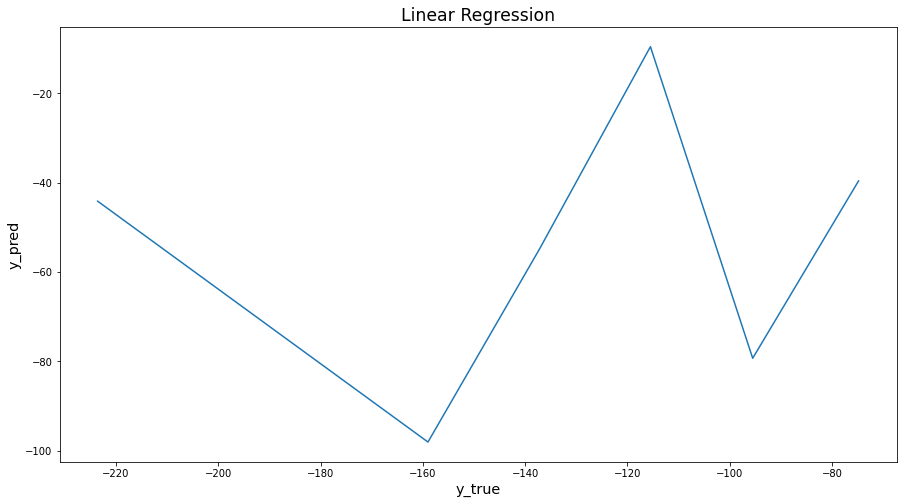

In [45]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y_test, y_pred)
ax.set_xlabel('y_true', fontsize='x-large')
ax.set_ylabel('y_pred', fontsize='x-large')
ax.set_title('Linear Regression', fontsize='xx-large')
plt.show()

In [46]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=21, splitter='best')

In [47]:
y_pred = tree_reg.predict(X_test)

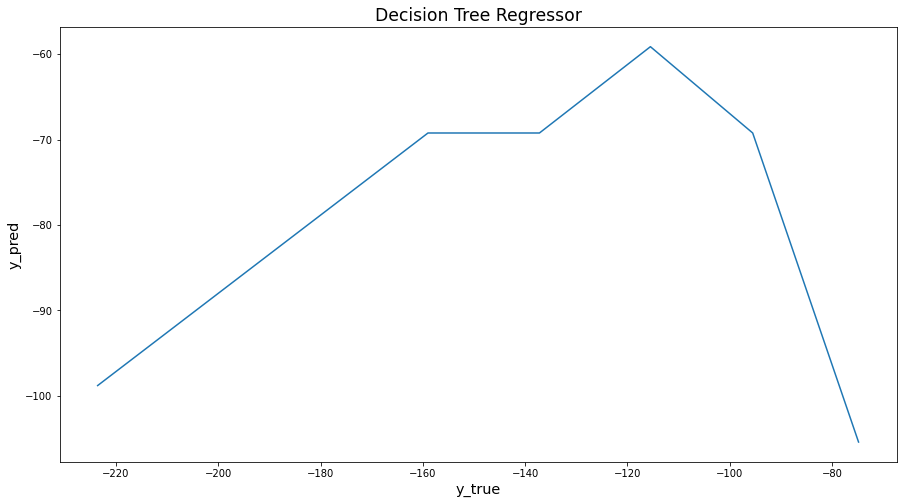

In [48]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y_test, y_pred)
ax.set_xlabel('y_true', fontsize='x-large')
ax.set_ylabel('y_pred', fontsize='x-large')
ax.set_title('Decision Tree Regressor', fontsize='xx-large')
plt.show()

In [49]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [50]:
y_pred = forest_reg.predict(X_test)

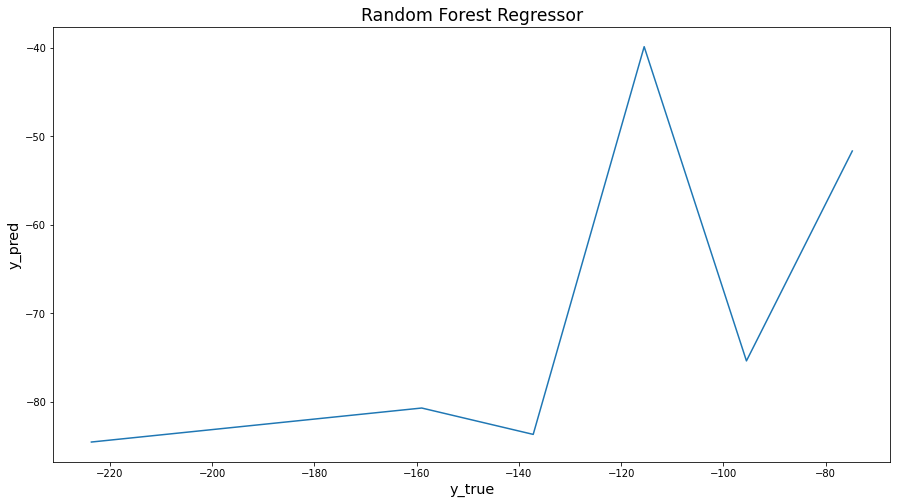

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y_test, y_pred)
ax.set_xlabel('y_true', fontsize='x-large')
ax.set_ylabel('y_pred', fontsize='x-large')
ax.set_title('Random Forest Regressor', fontsize='xx-large')
plt.show()